In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
import os
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url
# from utils.evaluation import find_landfalling_tcs,tc_region

In [2]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [3]:
# open storm dataset
tc_dir = '/user/home/al18709/work/event_sets/wgan_scalar/'
tc_dir = '/user/home/al18709/work/event_sets/wgan_modular/'
storm_filename = 'validation_mraw_2017253N14130.nc'
storm = xr.open_dataset(tc_dir + storm_filename)
storm_scores = np.load(tc_dir + 'validation_mraw_critic_2017253N14130.npy')

tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
storm_truth = xr.open_dataset(tc_dir_truth + 'validation_2017253N14130.nc')

tc_dir_wgan = '/user/home/al18709/work/event_sets/wgan/'
storm_wgan = xr.open_dataset(tc_dir_wgan + 'validation_2017253N14130.nc')

In [4]:
topography = xr.open_dataset('/user/home/al18709/work/topography/topography_10km_nn.nc')

In [5]:
print(topography)

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1800)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    z        (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  COARDS/CF-1.0
    history:      Fri Jan 06 13:22:57 2023: cdo remapnn,mygrid ETOPO1_Bed_g_g...
    title:        ETOPO1_Bed_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [6]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50,75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100

print(lats.shape)
print(lons.shape)


ntime,_,_,_ = storm.precipitation.shape
rain = storm.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


(100, 100)
(100, 100)


In [7]:
# find storm extent
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(139, 275)
(139, 275)


In [8]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))
grid_rain_wgan = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]
	storm_rain_wgan = storm_wgan.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	for i in range(20):
		storm_rain = storm.precipitation[t,:,:,i]
		grid_rain[t,sel[1],sel[0],i] = storm_rain
		grid_rain_wgan[t,sel[1],sel[0],i] = storm_rain_wgan
	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [9]:
total_storm_rain = np.sum(grid_rain[:,:,:,0],axis=0)
total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
print(np.sum(rain_bool))
rain_grid_x = grid_x[rain_bool]

rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

7026
7180


In [10]:
hit = (rain_bool == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss = (rain_bool == False) & (rain_bool_truth == True)
hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
print('Hit rate: ',hit_rate*100)

false_alarm = (rain_bool == True) & (rain_bool_truth == False)
correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
print('false alarm rate',false_alarm_rate*100)

# equitable threat score is:
# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# http://cimss.ssec.wisc.edu/goes/comet/threat.html
# ETS = (hits - E) / (hits + misses + false alarms - E)
# E = (number of forecast points * number of observed points) / total number of points possible

n_forecast_points = np.sum(rain_bool == True)
n_observed_points = np.sum(rain_bool_truth == True)
total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points*n_observed_points) / total_points_possible
ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
print('ETS: ', ETS)

# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

6567
Hit rate:  91.46239554317549
false alarm rate 1.4784989531325496
ETS:  0.8303601518326568


In [11]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [12]:
accumulated_rain = np.sum(grid_rain,axis=0)


In [13]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_119790/2558955332.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144


In [14]:
# plt.imshow(data)
print(np.min(data))
data[data == -inf] = 0

-inf


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


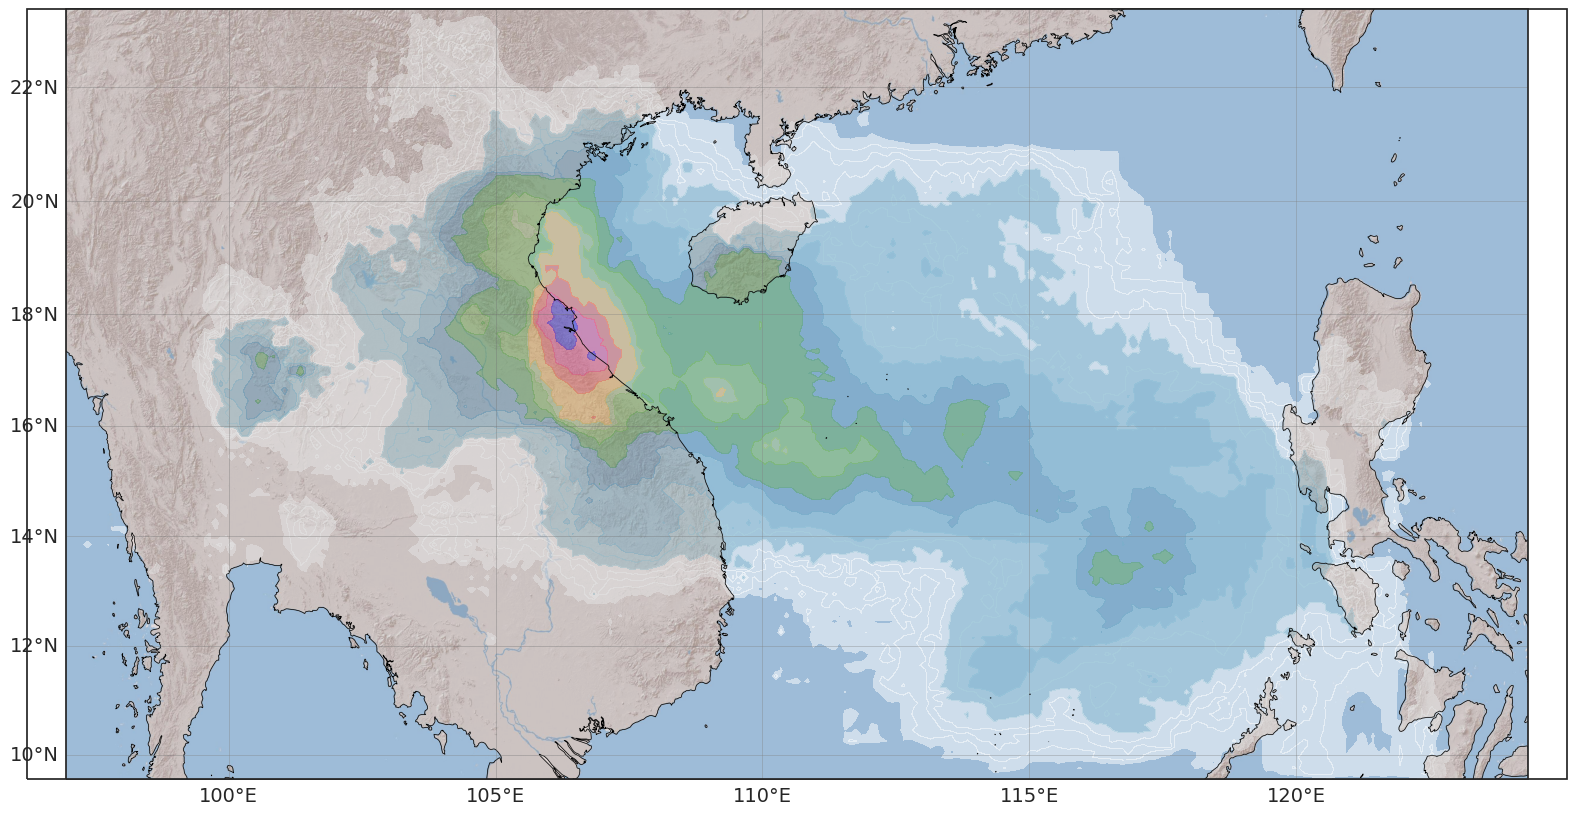

In [15]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300,350,400,450]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=450


fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

# ax.contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
# ax.contourf(lon,lat,topography.z.values, transform=ccrs.PlateCarree(),alpha=0.8)


# ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.add_image(ShadedReliefESRI(), 8)

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
ax.contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.5)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# ax.set_title('title',fontsize=26,pad=15)

plt.savefig('figure_10a_rain.png',bbox_inches='tight')

In [16]:
print(grid_x)
print(grid_y)

[[ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 ...
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]]
[[ 9.549998  9.549998  9.549998 ...  9.549998  9.549998  9.549998]
 [ 9.649997  9.649997  9.649997 ...  9.649997  9.649997  9.649997]
 [ 9.749995  9.749995  9.749995 ...  9.749995  9.749995  9.749995]
 ...
 [23.149998 23.149998 23.149998 ... 23.149998 23.149998 23.149998]
 [23.249996 23.249996 23.249996 ... 23.249996 23.249996 23.249996]
 [23.350002 23.350002 23.350002 ... 23.350002 23.350002 23.350002]]


In [17]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain[:,:,:,0],axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

global_rain[sel[1],sel[0]] = storm_rain
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
max rain 471.995989486786
max rain 390.9375044682027


In [18]:
def ets(total_storm_rain,total_storm_rain_truth,pop,threshold=50):

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	print('Hit rate: ',hit_rate*100)
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	print('false alarm rate',false_alarm_rate*100)
	pop_false_alarm = np.sum(pop[false_alarm])
	pop_correct_rejection = np.sum(pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	print('ETS population: ', ETS_pop)

	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [19]:
def CSI(total_storm_rain,total_storm_rain_truth,pop,threshold=50):

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	# print('Hit rate: ',hit_rate*100)
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	# print('false alarm rate',false_alarm_rate*100)
	pop_false_alarm = np.sum(pop[false_alarm])
	pop_correct_rejection = np.sum(pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)


	# n_forecast_points = np.sum(rain_bool == True)
	# n_observed_points = np.sum(rain_bool_truth == True)
	# total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	# E = (n_forecast_points*n_observed_points) / total_points_possible
	# ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	# print('ETS: ', ETS)
	csi = 1/(1/(1/hit_rate) + (1/(1-false_alarm_rate))+1)
	print('CSI: ', csi)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	# total_pp_pop = np.sum(pop[bool])
	# E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	# ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	# print('ETS population: ', ETS_pop)
	CSI_pop = 1/(1/(1/pop_hit_rate) + (1/(1-pop_false_alarm_rate)+1)) 
	print('CSI population: ', CSI_pop)

	return csi,CSI_pop

In [20]:
print(pop)

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0

print(global_pop.shape)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
(1800, 3600)


In [21]:
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain,global_rain_truth,global_pop)

Hit rate:  91.46239554317549
false alarm rate 0.007091190547551145
ETS:  0.859524335587636
ETS population:  0.92693144


In [22]:
print(pop_hit_rate * 100)
print(pop_false_alarm_rate * 100)
print(grid_rain.shape)
print(grid_rain_truth.shape)


97.49850034713745
0.07417466258630157
(28, 139, 275, 20)
(28, 139, 275)


In [23]:
n_time_steps,n,m,_ = grid_rain.shape
combo_rain = np.zeros((n_time_steps,n,m))
print(storm_scores.shape)
for t in range(n_time_steps):
	t_scores = storm_scores[t,:]
	best_score = np.argmax(t_scores)
	combo_rain[t,:,:] = grid_rain[t,:,:,best_score]

ensemble_combo = np.sum(combo_rain,axis=0)
print(t_scores)
print(ensemble_combo.shape)

(28, 1, 20)
[[47.54525757 48.75710297 48.02509689 47.73864746 47.93764114 47.6751709
  47.78130722 47.34612656 47.35216141 46.71697235 46.40663528 47.6869545
  48.37958145 48.20969009 47.85663605 48.21191025 48.05379868 48.06455231
  47.94090652 47.5953331 ]]
(139, 275)


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


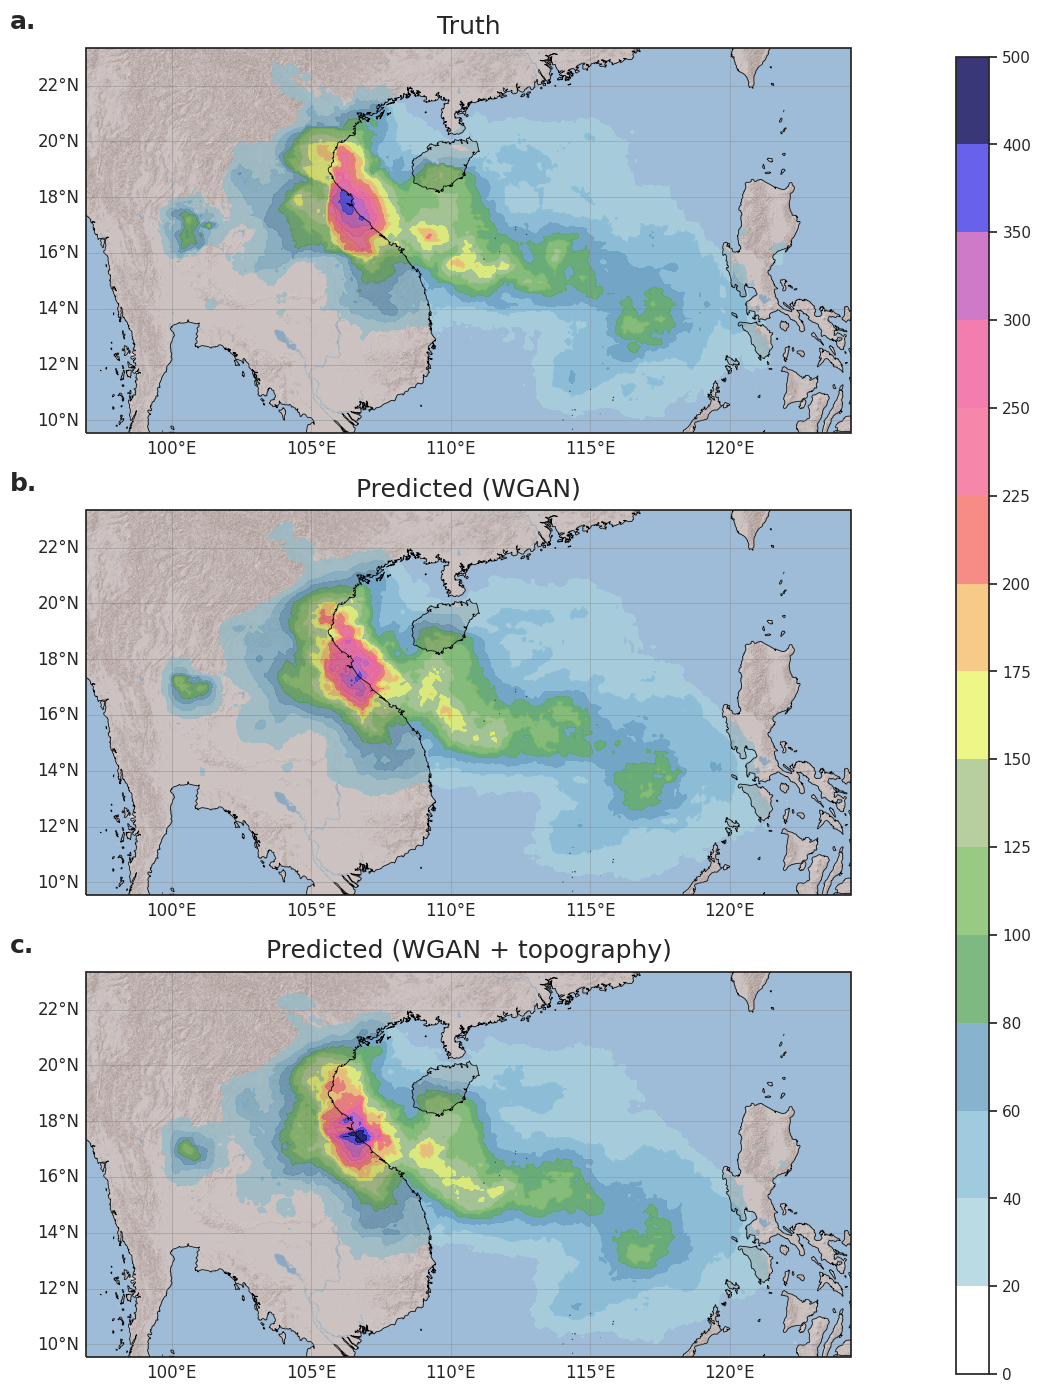

In [37]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=450


fig, axes = plt.subplots(3,1,figsize=(10,17),subplot_kw={'projection': ccrs.PlateCarree()})
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
m = axes[0].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
# axes[0] = plt.axes(projection=ShadedReliefESRI().crs)
axes[0].add_image(ShadedReliefESRI(), 8)
m.collections[0].set_alpha(0)
# second panel

agreement_range = 20
ensemble_max = np.max(np.sum(grid_rain[:,:,:,:],axis=0),axis=-1)
agree_mask = np.all([np.abs(np.sum(grid_rain[:,:,:,0],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,1],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,2],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,3],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,4],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,5],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,6],axis=0) - ensemble_max) <= agreement_range],
					axis=0)
print(agree_mask)
agree_mask = np.all([agree_mask,ensemble_max > 10],axis=0)
contour = axes[1].contourf(grid_x,grid_y,np.sum(grid_rain_wgan[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
contour.collections[0].set_alpha(0)
# axes[1] = plt.axes(projection=ShadedReliefESRI().crs)
axes[1].add_image(ShadedReliefESRI(), 8)


contour2 = axes[2].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
contour2.collections[0].set_alpha(0)
axes[2].add_image(ShadedReliefESRI(), 8)

# contour3 = axes[3].contourf(grid_x,grid_y,np.sum(grid_rain_wgan[:,:,:,0],axis=0) - np.sum(grid_rain[:,:,:,0],axis=0),vmin=-100,vmax=100,levels=levels,cmap = 'coolwarm',  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
# contour3.collections[0].set_alpha(0)
# axes[3].add_image(ShadedReliefESRI(), 8)

for i in range(3):
	axes[i].add_feature(cfeature.COASTLINE,linewidth=0.5)
	axes[i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


	# ax.outline_patch.set_linewidth(0.5)
	gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
	gl.xlabels_top = False
	gl.ylabels_right = False
	gl.xlabel_style = {'size': 12}
	gl.ylabel_style = {'size': 12}
	# ax.set_xticklabels(labelsize=20)
	# ax.set_yticklabels(labelsize=20)
	axes[i].tick_params(axis='x', labelsize=14)
	axes[i].tick_params(axis='y', labelsize=14)

# precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
	axes[i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=18, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=18, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=18, weight='bold')
# axes[3].text(-0.1, 1.05, 'd.', transform=axes[2].transAxes, size=18, weight='bold')
# axes[4].text(-0.1, 1.05, 'd.', transform=axes[4].transAxes, size=18, weight='bold')
# axes[5].text(-0.1, 1.05, 'e.', transform=axes[5].transAxes, size=18, weight='bold')
# legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
# axes[2].legend(handles=legend_handles, loc='upper right')

axes[0].set_title('Truth',fontsize=18,pad=10)
axes[1].set_title('Predicted (WGAN)',fontsize=18,pad=10)
axes[2].set_title('Predicted (WGAN + topography)',fontsize=18,pad=10)
# axes[3].set_title('Anomaly (WGAN - WGAN + t)',fontsize=18,pad=10)
# axes[3].set_title('Predicted (ensemble max)',fontsize=18,pad=10)
# axes[4].set_title('Standard deviation',fontsize=18,pad=10)
# axes[5].set_title('Hit and Miss',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

cbar_ax = fig.add_axes([1, 0.1, 0.033, 0.775])
cb = fig.colorbar(m, cax=cbar_ax,shrink=0.01,ticks=levels)
plt.savefig('figure_10b_topography.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most porbable rainfall (not mean) up to 95th percentile


In [25]:
# TODO 
# the question is, what level of extreme rainfall can we be confident in calculating the exposure to?
# how often are we wrong when it's 50mm,100mm,150mm
# how often are we right?
# do the ensemble combining method with critic score so best of 20 images are selected


In [26]:
# Analysis

# global stats, NH/SH split, basin split

# RMSE mountains vs flat

# ETS score (ETS_50mm ETS_100mm etc) mountains vs flat 

# CSI ?


# number of storms which track over mountains globally, NH, SH
# population exposure of mountain TC rainfall



In [27]:
print(storm_wgan.precipitation.shape)

(28, 100, 100, 20)


In [28]:
def globalise_storm_rain(storm,prediction=True):

	# define initial variables
	ntime,_,_,_ = storm.precipitation.shape

	# define global extent
	fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	grid_x, grid_y = np.meshgrid(lon,lat)

	# superimpose rain onto global grid
	if prediction == True:
		grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
	else:
		grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

	for t in range(ntime):
		storm_lons = storm.storm_lons[t,:,:]
		storm_lats = storm.storm_lats[t,:,:]

		Mlon = storm_lons[-1,-1]
		mlon = storm_lons[0,0]
		Mlat = storm_lats[-1,-1]
		mlat = storm_lats[0,0]
		if mlon.values > Mlon.values:
			continue
		Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
		Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

		# Create a selection
		sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

		if prediction == True:
			for i in range(20):
				storm_rain = storm.precipitation[t,:,:,i]
				grid_rain[t,sel[1],sel[0],i] = storm_rain
		else:
			storm_rain = storm.precipitation[t,:,:]
			grid_rain[t,sel[1],sel[0]] = storm_rain
	return grid_rain



In [29]:
global_rain_wgan = np.load('/user/home/al18709/work/event_sets/wgan/validation_global.npy')
global_rain_truth = np.load('/user/home/al18709/work/event_sets/truth/validation_global.npy')
global_rain_mwgan = np.load('/user/home/al18709/work/event_sets/wgan_modular/validation_mraw_global.npy')

In [30]:
print(global_rain_wgan.shape)

(1, 1800, 3600, 20)


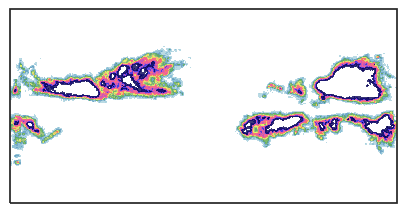

In [31]:
fig, axes = plt.subplots(1,1,figsize=(5,10),subplot_kw={'projection': ccrs.PlateCarree()})
axes.contourf(lon,lat,global_rain_wgan[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
plt.show()

In [32]:
land_mask = topography.z <= 0
sea_mask = topography.z >= 0
mountain_500m_mask = topography.z <= 500
mountain_1000m_mask = topography.z <= 1000
mountain_2000m_mask = topography.z <= 2000
mountain_3000m_mask = topography.z <= 3000

land_rain_wgan = np.copy(global_rain_wgan)
sea_rain_wgan = np.copy(global_rain_wgan)
mountain_500m_rain_wgan = np.copy(global_rain_wgan)
mountain_1000m_rain_wgan = np.copy(global_rain_wgan)
mountain_2000m_rain_wgan = np.copy(global_rain_wgan)
mountain_3000m_rain_wgan = np.copy(global_rain_wgan)

land_rain_mwgan = np.copy(global_rain_mwgan)
sea_rain_mwgan = np.copy(global_rain_mwgan)
mountain_500m_rain_mwgan = np.copy(global_rain_mwgan)
mountain_1000m_rain_mwgan = np.copy(global_rain_mwgan)
mountain_2000m_rain_mwgan = np.copy(global_rain_mwgan)
mountain_3000m_rain_mwgan = np.copy(global_rain_mwgan)

land_rain_truth = np.copy(global_rain_truth)
sea_rain_truth = np.copy(global_rain_truth)
mountain_500m_rain_truth = np.copy(global_rain_truth)
mountain_1000m_rain_truth = np.copy(global_rain_truth)
mountain_2000m_rain_truth = np.copy(global_rain_truth)
mountain_3000m_rain_truth = np.copy(global_rain_truth)

masks = [land_mask,sea_mask,mountain_500m_mask,mountain_1000m_mask,mountain_2000m_mask,mountain_3000m_mask]
wgan_rain = [land_rain_wgan,sea_rain_wgan,mountain_500m_rain_wgan,mountain_1000m_rain_wgan,mountain_2000m_rain_wgan,mountain_3000m_rain_wgan]
mwgan_rain = [land_rain_mwgan,sea_rain_mwgan,mountain_500m_rain_mwgan,mountain_1000m_rain_mwgan,mountain_2000m_rain_mwgan,mountain_3000m_rain_mwgan]
truth_rain = [land_rain_truth,sea_rain_truth,mountain_500m_rain_truth,mountain_1000m_rain_truth,mountain_2000m_rain_truth,mountain_3000m_rain_truth]

for i,mask in enumerate(masks):
	wgan_rain[i][0,mask,:] = 0
	mwgan_rain[i][0,mask,:] = 0
	truth_rain[i][mask] = 0
# print(mountain_rain.shape)


In [33]:
def rmse(real,pred):
	return np.sqrt(np.mean((pred - real)**2))


In [34]:
# count of how many storms in each section, storms or time points
print('---------------------')
print('total rain over land')
print('---------------------')
print('WGAN: ',np.mean(np.sum(land_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(land_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(land_rain_truth))
print('RMSE WGAN: ',rmse(land_rain_truth,land_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(land_rain_truth,land_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_wgan[0,:,:,0],land_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_wgan[0,:,:,0],land_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_wgan[0,:,:,0],land_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(sea_rain_wgan[0,:,:,0],land_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(land_rain_wgan[0,:,:,0],land_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(land_rain_wgan[0,:,:,0],land_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(land_rain_mwgan[0,:,:,0],land_rain_truth,global_pop,threshold=150)


print('-------------------')
print('total rain over sea')
print('-------------------')
print('WGAN: ',np.mean(np.sum(sea_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(sea_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(sea_rain_truth))
print('RMSE WGAN: ',rmse(sea_rain_truth,sea_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(sea_rain_truth,sea_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(sea_rain_wgan[0,:,:,0],sea_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(sea_rain_mwgan[0,:,:,0],sea_rain_truth,global_pop,threshold=150)



print('------------------------------')
print('total rain over mountains 500m')
print('------------------------------')
print('WGAN: ',np.mean(np.sum(mountain_500m_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(mountain_500m_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(mountain_500m_rain_truth))
print('RMSE WGAN: ',rmse(mountain_500m_rain_truth,mountain_500m_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(mountain_500m_rain_truth,mountain_500m_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_wgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(mountain_500m_rain_mwgan[0,:,:,0],mountain_500m_rain_truth,global_pop,threshold=150)


print('-------------------------------')
print('total rain over mountains 1000m')
print('-------------------------------')
print('WGAN: ',np.mean(np.sum(mountain_1000m_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(mountain_1000m_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(mountain_1000m_rain_truth))
print('RMSE WGAN: ',rmse(mountain_1000m_rain_truth,mountain_1000m_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(mountain_1000m_rain_truth,mountain_1000m_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_wgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(mountain_1000m_rain_mwgan[0,:,:,0],mountain_1000m_rain_truth,global_pop,threshold=150)


print('-------------------------------')
print('total rain over mountains 2000m')
print('-------------------------------')
print('WGAN: ',np.mean(np.sum(mountain_2000m_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(mountain_2000m_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(mountain_2000m_rain_truth))
print('RMSE WGAN: ',rmse(mountain_2000m_rain_truth,mountain_2000m_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(mountain_2000m_rain_truth,mountain_2000m_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_wgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(mountain_2000m_rain_mwgan[0,:,:,0],mountain_2000m_rain_truth,global_pop,threshold=150)


print('------------------------------')
print('total rain over mountains 3000m')
print('------------------------------')
print('WGAN: ',np.mean(np.sum(mountain_3000m_rain_wgan,axis=(0,1,2))))
print('MWGAN: ',np.mean(np.sum(mountain_3000m_rain_mwgan,axis=(0,1,2))))
print('Truth: ',np.sum(mountain_3000m_rain_truth))
print('RMSE WGAN: ',rmse(mountain_3000m_rain_truth,mountain_3000m_rain_wgan[0,:,:,0]))
print('RMSE MWGAN: ',rmse(mountain_3000m_rain_truth,mountain_3000m_rain_mwgan[0,:,:,0]))
print('ETS50 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop)
print('ETS50 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop)
print('ETS100 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=100)
print('ETS100 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=100)
print('ETS150 WGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=150)
print('ETS150 MWGAN: ')
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=150)
print('CSI50 WGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop)
print('CSI50 MWGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop)
print('CSI100 WGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=100)
print('CSI100 MWGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=100)
print('CSI150 WGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_wgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=150)
print('CSI150 MWGAN: ')
csi,csi_pop = CSI(mountain_3000m_rain_mwgan[0,:,:,0],mountain_3000m_rain_truth,global_pop,threshold=150)


---------------------
total rain over land
---------------------
WGAN:  23893524.614990838
MWGAN:  25036382.363977976
Truth:  25722544.132654734
RMSE WGAN:  17.313228876442082
RMSE MWGAN:  6.477676273812799
ETS50 WGAN: 
Hit rate:  87.47272748486157
false alarm rate 0.15643642117632744
ETS:  0.7807334276863179
ETS population:  0.7787544
ETS50 MWGAN: 
Hit rate:  96.11709388745639
false alarm rate 0.05176492593158491
ETS:  0.9244699851273004
ETS population:  0.93883383
ETS100 WGAN: 
Hit rate:  86.90097459980811
false alarm rate 0.12637465927980773
ETS:  0.7626587400093573
ETS population:  0.82059985
ETS100 MWGAN: 
Hit rate:  94.6018280058577
false alarm rate 0.03845440396374726
ETS:  0.9074667321000444
ETS population:  0.9605981
ETS150 WGAN: 
Hit rate:  83.74763967566366
false alarm rate 0.11182621249311382
ETS:  0.7203806435650512
ETS population:  0.80658984
ETS150 MWGAN: 
Hit rate:  94.10640897478618
false alarm rate 0.02991459964553142
ETS:  0.9018278060043946
ETS population:  0.939819

/tmp/ipykernel_119790/30666658.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  csi = 1/(1/(1/hit_rate) + (1/(1-false_alarm_rate))+1)
/tmp/ipykernel_119790/30666658.py:43: RuntimeWarning: divide by zero encountered in divide
  CSI_pop = 1/(1/(1/pop_hit_rate) + (1/(1-pop_false_alarm_rate)+1))


CSI:  0.4660231121135086
CSI population:  0.3700689034821277
CSI50 MWGAN: 
CSI:  0.33764519115345853
CSI population:  0.3354498153149463
CSI100 WGAN: 
CSI:  0.3483986614743483
CSI population:  0.34548767171915024
CSI100 MWGAN: 
CSI:  0.3393968881694718
CSI population:  0.33551492072874267
CSI150 WGAN: 
CSI:  0.352286845830441
CSI population:  0.35123773120035867
CSI150 MWGAN: 
CSI:  0.33997840097220977
CSI population:  0.3387019241318848
-------------------
total rain over sea
-------------------
WGAN:  381116529.94181365
MWGAN:  378964077.6138487
Truth:  383528993.4395588
RMSE WGAN:  58.17756719972003
RMSE MWGAN:  12.265199234709295
ETS50 WGAN: 
Hit rate:  93.47628716648777
false alarm rate 1.5940309701250617
ETS:  0.8156517927245907
ETS population:  0.89966965
ETS50 MWGAN: 
Hit rate:  98.40509046701413
false alarm rate 0.19238486084120845
ETS:  0.9663179191317757
ETS population:  0.97642154
ETS100 WGAN: 
Hit rate:  94.12709424814398
false alarm rate 1.2321746937673683
ETS:  0.8284491

/tmp/ipykernel_119790/2144838214.py:15: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_119790/2144838214.py:45: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


ETS:  0.4999981761998571
ETS population:  nan
ETS150 MWGAN: 
Hit rate:  57.692307692307686
false alarm rate 6.172864273838136e-05
ETS:  0.4999987294206396
ETS population:  nan
CSI50 WGAN: 
CSI:  0.33653840910355676
CSI population:  0.33856522919927173
CSI50 MWGAN: 
CSI:  0.33653837414693566
CSI population:  0.3385651649743666
CSI100 WGAN: 
CSI:  0.3488370215116374
CSI population:  0.5
CSI100 MWGAN: 
CSI:  0.35714262093534227
CSI population:  0.4999999513499583
CSI150 WGAN: 
CSI:  0.35135100843887956
CSI population:  nan
CSI150 MWGAN: 
CSI:  0.3880596085351342
CSI population:  nan


In [35]:
print(np.sum(global_rain_wgan,axis=(0,1,2)))
print(np.sum(global_rain_mwgan,axis=(0,1,2)))

[4.05206422e+08 4.05275082e+08 4.05175728e+08 4.05149331e+08
 4.05220561e+08 4.05229523e+08 4.05197174e+08 4.05173661e+08
 4.05204400e+08 4.05248923e+08 4.05128990e+08 4.05209293e+08
 4.05247287e+08 4.05243464e+08 4.05199932e+08 4.05262308e+08
 4.05244855e+08 4.05138876e+08 4.05133351e+08 4.05214276e+08]
[4.04194812e+08 4.04104338e+08 4.04226045e+08 4.04200040e+08
 4.04161217e+08 4.04192655e+08 4.04205778e+08 4.04141158e+08
 4.04230384e+08 4.04223602e+08 4.04266301e+08 4.04259579e+08
 4.04231091e+08 4.04150763e+08 4.04152896e+08 4.04153766e+08
 4.04184746e+08 4.04207198e+08 4.04219149e+08 4.04166465e+08]


NameError: name 'mountain_rain_mwgan' is not defined

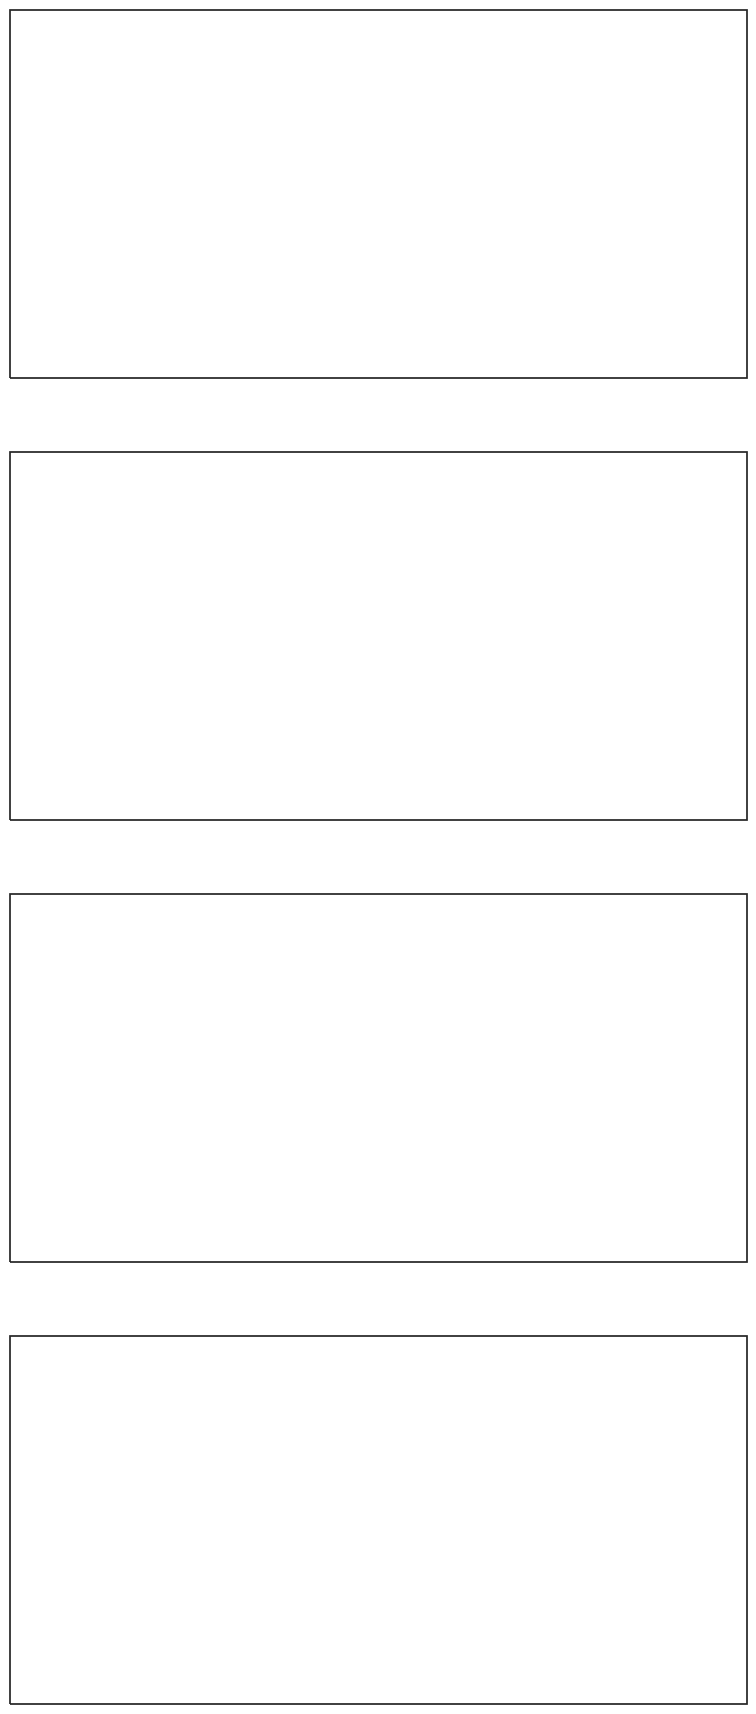

In [36]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=450


fig, axes = plt.subplots(4,1,figsize=(10,22),subplot_kw={'projection': ccrs.PlateCarree()})
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
m = axes[0].contourf(lon,lat,mountain_rain_mwgan[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
axes[0].add_image(ShadedReliefESRI(), 8)
m.collections[0].set_alpha(0)

# second panel
contour = axes[1].contourf(lon,lat,mountain_rain_wgan[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
contour.collections[0].set_alpha(0)
# axes[1] = plt.axes(projection=ShadedReliefESRI().crs)
axes[1].add_image(ShadedReliefESRI(), 8)

# third panel
contour2 = axes[2].contourf(lon,lat,mountain_rain_mwgan[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
contour2.collections[0].set_alpha(0)
axes[2].add_image(ShadedReliefESRI(), 8)

contour3 = axes[3].contourf(lon,lat,mountain_rain_wgan[0,:,:,0] - mountain_rain_mwgan[0,:,:,0],vmin=-100,vmax=100,levels=levels,cmap = 'coolwarm',  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
# contour3.collections[0].set_alpha(0)
axes[3].add_image(ShadedReliefESRI(), 8)

for i in range(3):
	axes[i].add_feature(cfeature.COASTLINE,linewidth=0.5)
	axes[i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


	# ax.outline_patch.set_linewidth(0.5)
	gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
	gl.xlabels_top = False
	gl.ylabels_right = False
	gl.xlabel_style = {'size': 12}
	gl.ylabel_style = {'size': 12}
	# ax.set_xticklabels(labelsize=20)
	# ax.set_yticklabels(labelsize=20)
	axes[i].tick_params(axis='x', labelsize=14)
	axes[i].tick_params(axis='y', labelsize=14)
	axes[i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())


axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=18, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=18, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=18, weight='bold')
axes[3].text(-0.1, 1.05, 'd.', transform=axes[2].transAxes, size=18, weight='bold')

axes[0].set_title('Truth',fontsize=18,pad=10)
axes[1].set_title('Predicted (WGAN)',fontsize=18,pad=10)
axes[2].set_title('Predicted (WGAN + topography)',fontsize=18,pad=10)
axes[3].set_title('Anomaly (WGAN - WGAN + t)',fontsize=18,pad=10)

cbar_ax = fig.add_axes([1, 0.1, 0.033, 0.775])
cb = fig.colorbar(m, cax=cbar_ax,shrink=0.01,ticks=levels)
plt.savefig('figure_10c_mountain_rain.png',bbox_inches='tight')

